In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale


import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics
import matplotlib.pyplot as plt  


In [2]:
train_orig = pd.read_csv( "/Users/shaan/Downloads/DataSet/train.csv" )
train_orig=pd.DataFrame(train_orig)
train=train_orig.drop(['SalePrice'],axis=1)
test_orig = pd.read_csv( "/Users/shaan/Downloads/DataSet/test.csv" )
test_orig=pd.DataFrame(test_orig)

In [3]:
#cleaning
def cleanCat(categoricalData):
    categoricalData["MSZoning"].replace('C (all)', 'C',inplace=True)
    categoricalData["Alley"].replace(np.nan, 'NA',inplace=True)
    categoricalData["MasVnrType"].replace(np.nan, 'None',inplace=True)#CHECK THIS
    categoricalData.replace(np.nan, 'NA',inplace=True)
    categoricalData["Exterior2nd"].replace('CmentBd', 'CemntBd',inplace=True)
    categoricalData["Exterior2nd"].replace('Brk Cmn', 'BrkComm',inplace=True)
    categoricalData["Exterior2nd"].replace('Wd Shng', 'WdShing',inplace=True)
    return categoricalData

In [4]:
#encode
def encodeCat(categoricalData):
    categoricalData=cleanCat(categoricalData)
    encodedCategoricalData=pd.get_dummies(categoricalData)
    return encodedCategoricalData

In [5]:
#process numerical data
def processNonCat(nonCategoricalData):
    nonCategoricalData=nonCategoricalData.drop(['Id','TotalBsmtSF'],axis=1)
    nonCategoricalData.replace(np.nan, 0,inplace=True)#check
    nonCategoricalData.describe()
    yearCols=['YrSold','YearBuilt','YearRemodAdd','MoSold','GarageYrBlt']
    for col in yearCols:
        nonCategoricalData[col]=nonCategoricalData[col]-math.floor(np.average(nonCategoricalData[col]))

    areaCols=['LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
          '1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','GarageArea','WoodDeckSF',
          'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea']
#TotalBsmtSF = type1 + type2 + unfin (check)
    for col in areaCols:
        nonCategoricalData[col]=np.sqrt(nonCategoricalData[col])

    nonCategoricalData['MiscVal']=np.log(nonCategoricalData['MiscVal']+10)-np.log(10)
    nonCategoricalData.describe()
    return nonCategoricalData
#scaler = StandardScaler().fit(nonCategoricalData)
#scaledNonCategoricalData=scaler.transform(nonCategoricalData)
#scaledNonCategoricalData=pd.DataFrame(scaledNonCategoricalData)
#scaledNonCategoricalData.columns=nonCategoricalData.columns

In [6]:
def processData(train):
    categoricalData=train.select_dtypes(include='object').copy()
    nonCategoricalData=train.select_dtypes(exclude='object').copy()
    encodedCategoricalData=encodeCat(categoricalData)
    nonCategoricalData=processNonCat(nonCategoricalData)
    X_train=pd.concat([nonCategoricalData, encodedCategoricalData],axis=1)
    return X_train

In [58]:
X_train = processData(train)
X_test_orig = processData(test_orig)

In [59]:
#make sure the columns are the same and in same order
for col in X_train.columns:
    if col not in X_test_orig.columns:
        X_test_orig[col]=np.zeros(X_test_orig.shape[0])
X_test_orig=X_test_orig[X_train.columns]

In [60]:
Y_train=train_orig["SalePrice"]
Y_train=np.log(Y_train)

In [61]:
#split into test and train
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)
print("X_train shape = ", X_train.shape)
print("Y_train shape = ", Y_train.shape)

X_train shape =  (1314, 302)
Y_train shape =  (1314,)


In [62]:
#remove zero columns from train and the respective columns from test
X_train = X_train.loc[:, (X_train != 0).any(axis=0)]
print("X_train shape after removing zeros = ", X_train.shape)

X_train shape after removing zeros =  (1314, 301)


In [63]:
X_test=X_test[X_train.columns]
X_test_orig=X_test_orig[X_train.columns]

In [64]:
def printErrors(Y_train,Y_pred):
    print('Mean Absolute Error:', metrics.mean_absolute_error(Y_train, Y_pred))  
    print('Mean Squared Error:', metrics.mean_squared_error(Y_train, Y_pred))  
    print('Root Mean Squared log Error:', np.sqrt(metrics.mean_squared_error(np.log(Y_train), np.log(Y_pred))))
    print('Mean % error:',)

['Street_Pave', 'Utilities_NoSeWa', 'Exterior2nd_CBlock', 'Exterior2nd_CemntBd', 'Exterior2nd_MetalSd', 'Exterior2nd_VinylSd', 'BsmtCond_NA', 'BsmtExposure_NA', 'BsmtFinType1_NA', 'BsmtFinType2_NA', 'CentralAir_Y', 'GarageType_NA', 'GarageFinish_NA', 'GarageQual_NA', 'GarageCond_NA', 'PoolQC_NA', 'MiscFeature_NA', 'SaleCondition_Partial']


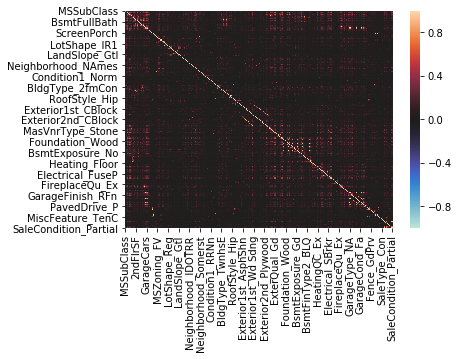

In [65]:
corr_matrix = X_train.corr().abs()
sns.heatmap(corr_matrix,vmin=-1, vmax=1, center= 0)

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]
print(to_drop)

In [66]:
#drop high corr columns
X_train=X_train.drop(to_drop,axis=1)
#X_test=X_test.drop(to_drop,axis=1)
X_test_orig=X_test_orig.drop(to_drop,axis=1)
X_test=X_test.drop(to_drop,axis=1)
X_train.shape

(1314, 283)

In [67]:
#basic regression
regressor = LinearRegression()  
regressor.fit(X_train, Y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [68]:
def printErrorsMega(regressor,X_train,X_test,Y_train,Y_test):
    y_pred_train = regressor.predict(X_train)
    y_pred = regressor.predict(X_test)
    y_pred_train=np.maximum(y_pred_train,0)
    y_pred=np.maximum(y_pred,0)
    print("train errors:")
    printErrors(np.exp(Y_train),np.exp(y_pred_train))
    print("test errors:")
    printErrors(np.exp(Y_test),np.exp(y_pred))

In [69]:
printErrorsMega(regressor,X_train,X_test,Y_train,Y_test)
#printErrors((Y_train),(y_pred_train))
#printErrors((Y_test),(y_pred))

train errors:
Mean Absolute Error: 10861.311823189806
Mean Squared Error: 300815742.0623012
Root Mean Squared log Error: 0.09058425255038964
Mean % error:
test errors:
Mean Absolute Error: 16701.365404674852
Mean Squared Error: 638613881.7930237
Root Mean Squared log Error: 0.13329375142281844
Mean % error:


In [70]:
#adaboost
errors=[];
#for lr in np.arange(0.01, 0.2, 0.05):
#    reg=AdaBoostRegressor(loss='square',n_estimators=100,learning_rate=lr)
#    reg.fit(X_train,Y_train)
    #errors
#    y_pred_train = reg.predict(X_train)
#    y_pred_train=np.maximum(y_pred_train,0)
#    errors.append(metrics.mean_squared_error(Y_train, y_pred_train))

In [71]:
#print("errors vs learning rate")
#sns.lineplot(x=np.arange(0.01, 0.2, 0.05), y=errors,legend='full');

In [72]:
#errors
#y_pred_train = reg.predict(X_train)
#y_pred = reg.predict(X_test)
#print("train errors:")
#printErrors(Y_train,y_pred_train)
#print("test errors:")
#printErrors(Y_test,y_pred)

In [42]:
#sns.pairplot(data=X_train[['BsmtFinSF2', 'BsmtUnfSF']], diag_kind = 'kde'
#             ,plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'})


In [43]:
#data=X_train
#data=data.join(pd.DataFrame({"Y_val":Y_train}))
#data.columns

In [44]:
#sns.relplot(x="MSSubClass", y="Y_val",col='OverallQual', data=data)

In [45]:
#random forest regressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000,n_jobs=-1,warm_start=True)
# Train the model on training data
rf.fit(X_train, Y_train);

KeyboardInterrupt: 

In [ ]:
printErrorsMega(rf,X_train,X_test,Y_train,Y_test)


In [359]:
model=rf
y_pred=model.predict(X_test)

In [360]:
importance=model.feature_importances_
sns.set_color_codes("pastel")
ranges=np.arange(0,10,1)
#f, ax = plt.subplots(figsize=(6, 15))
#sns.barplot(importance[ranges],X_train.columns[ranges])

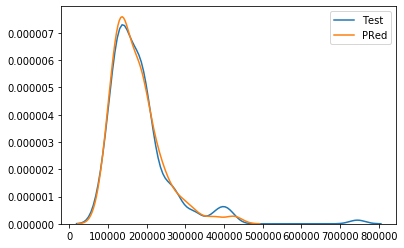

In [361]:
#plt.hist([Y_test,y_pred], color=['r','b'], alpha=0.5)

sns.kdeplot(np.exp(Y_test),label='Test')
sns.kdeplot(np.exp(y_pred),label='PRed')

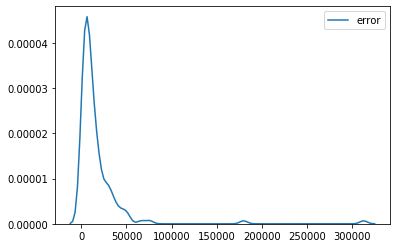

In [362]:
sns.kdeplot(abs(np.exp(y_pred)-np.exp(Y_test)),label='error')

In [368]:
print(np.where(abs(np.exp(y_pred)-np.exp(Y_test))>100000))
print((np.exp(y_pred)-np.exp(Y_test))[73:74])

(array([ 8, 73]),)
688   -179792.05769
Name: SalePrice, dtype: float64


In [370]:
X_test[8:9]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal
1182,60,160.0,124.992,10,5,25,12,0.0,45.782093,0.0,...,0,0,0,0,1,1,0,0,0,0


In [369]:
print(np.exp(Y_test)[8:9])
print(np.exp(y_pred)[8:9])

1182    745000.0
Name: SalePrice, dtype: float64
[432338.75393654]


In [19]:
y_pred = regressor.predict(X_test_orig)
y_pred_exp=np.exp(y_pred)

In [20]:
y_pred_df=pd.DataFrame()
y_pred_df["Id"]=range(1461,1461+len(y_pred),1)
y_pred_df["SalePrice"]=y_pred_exp
y_pred_df.to_csv("/Users/shaan/Downloads/DataSet/my_submission4.csv",index=False)

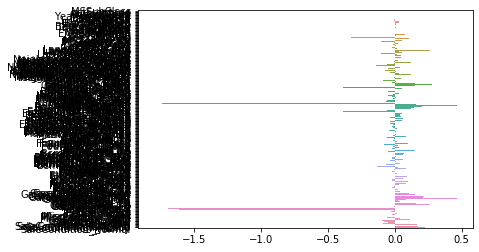

In [397]:
sns.barplot(regressor.coef_,X_train.columns)

In [7]:
#analyse data
categoricalData=train.select_dtypes(include='object').copy()
nonCategoricalData=train.select_dtypes(exclude='object').copy()

In [9]:
categoricalData.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

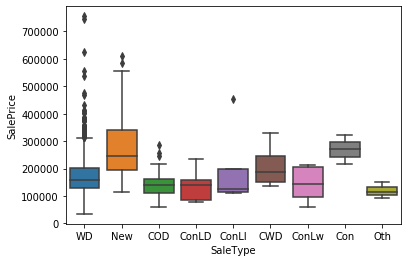

In [34]:
sns.boxplot(x='SaleType',y='SalePrice',data=train_orig)